In [1]:
from __future__ import print_function
import torch
import argparse
import sys
sys.path.append("../")
import platform
from datetime import timedelta, date, datetime
import numpy as np
import os
import time
import util.data_processing_tool as dpt
from netCDF4 import Dataset
import cv2
import tqdm
from joblib import Parallel, delayed


np.seterr(invalid='ignore')

class QMap():
    def __init__(self, step=0.01):
        self.step = step

    def fit(self, x, y, axis=None):
        if axis not in (None, 0):
            raise ValueError("Axis should be None or 0")
        self.axis = axis
        steps = np.arange(0, 100, self.step)
        self.x_map = np.percentile(x, steps, axis=axis)
        self.y_map = np.percentile(y, steps, axis=axis)
        return self

    def predict(self, y):
        idx = [np.abs(val - self.y_map).argmin(axis=self.axis) for val in y]
        if self.axis == 0:
            out = np.asarray([self.x_map[k, range(y.shape[1])] for k in idx])
        else:
            out = self.x_map[idx]
        return out

def mapper(x, y, train_num, step=0.01):
    qmap = QMap(step=step)
    qmap.fit(x[:train_num], y[:train_num], axis=0)
    return qmap.predict(y)

E:\Users\Weifa\Anaconda3\envs\py37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
E:\Users\Weifa\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
E:\Users\Weifa\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
E:\Users\Weifa\Anaconda3\envs\py37\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [14]:
# from __future__ import print_function
import torch
import argparse
import sys
sys.path.append("../")
import platform
from datetime import timedelta, date, datetime
import numpy as np
import os
import time
import util.data_processing_tool as dpt
from netCDF4 import Dataset
import cv2
import tqdm
from joblib import Parallel, delayed


np.seterr(invalid='ignore')

class QMap():
    def __init__(self, step=0.01):
        self.step = step

    def fit(self, x, y, axis=None):
        if axis not in (None, 0):
            raise ValueError("Axis should be None or 0")
        self.axis = axis
        steps = np.arange(0, 100, self.step)
        self.x_map = np.percentile(x, steps, axis=axis)
        self.y_map = np.percentile(y, steps, axis=axis)
        return self

    def predict(self, y):
        idx = [np.abs(val - self.y_map).argmin(axis=self.axis) for val in y]
        if self.axis == 0:
            out = np.asarray([self.x_map[k, range(y.shape[1])] for k in idx])
        else:
            out = self.x_map[idx]
        return out

def mapper(x, y, train_num, step=0.01):
    qmap = QMap(step=step)
    qmap.fit(x[:train_num], y[:train_num], axis=0)
    return qmap.predict(y)


# years_for_evaluation=[1997,]
def get_windows(leading,time_windows=1,max_leading=217):
    if leading-time_windows<0:
        upper_win=time_windows*2+1
        lower_win=0

    elif leading+time_windows>=max_leading-1:
        upper_win=max_leading
        lower_win=max_leading-time_windows*2-1
    else:
        upper_win=leading+time_windows+1
        lower_win=leading-time_windows
    idx_win=list(range(lower_win,upper_win))
    return idx_win


def main(years_for_evaluation=None,time_windows=2):
#     file_ACCESS_dir='/g/data/ub7/access-s1/hc/raw_model/atmos/pr/daily/'  #                     # ?NCI?
    file_ACCESS_dir='F:/Climate_change/Data/pr/daily/'
    file_BARRA_dir='../../Data/barra_aus/barra_upscaled/'
    file_BARRA_dir_ori='../../Data/barra_aus/'

    file_save='../../Data/bcsd/daily/'
    scale_factor=np.load('./scale_factor.npy')
    data,lat,lon=dpt.add_lat_lon_data(np.zeros((316,376)))
    
    for en in ['e01','e02','e03','e04','e05','e06','e07','e08','e09','e10','e11']:
        filr_dir=file_ACCESS_dir+en+'/'
        file_list=dpt.list_all_files(filr_dir)[:48]
        
####################################
#         print(file_list)
#  ????1990???????
#
        for file in file_list:

            ensemble_mem=[]
#             year=[]
            historical_year=file.split('/')[-1][6:10]
            historical_month=file.split('/')[-1][10:12]
            historical_day=file.split('/')[-1][12:14] 
            for y in range(1990,2013):
                
                data=Dataset(filr_dir+"da_pr_"+str(y)+historical_month+historical_day+"_"+en+".nc")
                var=data['pr'][:]*86400                           # ?NCI?
                
#                 var=dpt.interp_tensor_3d(data['pr'][:][:,82:144,134:188],(79,94))*86400                           # ?NCI?
                ensemble_mem.append(var)
#                 year.append(np.ones(var.shape)*y)
                data.close()
#             print(np.array(ensemble_mem).shape)
            
            ensemble_mem=np.array(ensemble_mem)  #used for train
#             year=np.array(year)
#             print(np.array(year).shape)


            mapped_data=np.zeros((23,ensemble_mem.shape[1],316,376))
    
    
#             print(mapped_data.shape)
            for leading in range(ensemble_mem.shape[1]):                                            # ?NCI?

#                 print(1)
                idx_win=get_windows(leading,time_windows,ensemble_mem.shape[1])
                curr_idx=np.where(np.array(idx_win)==leading)[0]
                idx_dayoftime=(date(int(historical_year),int(historical_month),int(historical_day))+timedelta(leading)).timetuple().tm_yday-1
#                 print(idx_dayoftime)
#                 print(ensemble_mem.shape[1])
#                 print(curr_idx)
#                 print(ensemble_mem[:,idx_win].reshape((-1,79,94)).shape)
                ensemble_train=ensemble_mem[:,idx_win].reshape((-1,79,94))   #modeled->x
#                 year_train=year[:,idx_win].reshape((-1,79,94))
#                 print(ensemble_train.shape)
#                 print(leading)
        ###################################################################################################################
#               barra ????
                ensamble=[]
                for ix in idx_win:
#                     print(ix)
                    for y in range(1990,2013):
                        target_date=date(int(historical_year),int(historical_month),int(historical_day))+timedelta(ix)
                        filename=file_BARRA_dir+str(y)+(target_date+timedelta(1)).strftime("%m%d")+".nc"
                        if os.path.exists(filename):
                            sr=dpt.read_barra_data_fc(file_BARRA_dir,target_date)
                            ensamble.append(sr)
                        else:
                            print(filename)
                            print(target_date)
                ensamble_obs=np.array(ensamble)
                
                ensamble=[]
                for ix in idx_win:
#                     print(ix)
                    for y in range(1990,2013):
                        target_date=date(y,int(historical_month),int(historical_day))+timedelta(ix)
                        filename=file_BARRA_dir_ori+(target_date+timedelta(1)).strftime("%Y%m%d")+".nc"
                        if os.path.exists(filename):
                            sr=dpt.read_barra_data_fc(file_BARRA_dir_ori,target_date)
                            ensamble.append(sr)
                        else:
                            print(int(historical_year),int(historical_month),int(historical_day),leading)
                            print(ix)
                            print(filename)
                            print(target_date)
                            print(y)
                ensamble_obs_origin=np.array(ensamble)
#                 print(2)
                if not ensamble_obs.shape ==ensemble_train.shape:
                    print(historical_year,historical_month,historical_day,leading)
                    print(ensamble_obs.shape,ensemble_train.shape)

################################################################################################################### 
        
###################################################################################################################
                jobs=[]
                for i in range(ensemble_train.shape[1]):
                    X_lat = ensamble_obs[:,i]
#                     print(X_lat.shape)
                    Y_lat = ensemble_train[:,i]
#                     print(Y_lat.shape)
                    jobs.append(delayed(mapper)(X_lat, Y_lat, 69, 0.01))
###################################################################################################################
                day_mapped = np.asarray(Parallel(n_jobs=16)(jobs))
                day_mapped = np.swapaxes(day_mapped, 0, 1)
                day_mapped = dpt.interp_tensor_3d(day_mapped, size=(316,376))
                

                mapped_data[:,[leading]]=day_mapped.reshape(-1,5,316,376)[:,curr_idx]*scale_factor[idx_dayoftime]
####################################################

            #baocun
                
#             print(3)
            for i,y in enumerate(range(1990,2013)):
                path_dir=file_save+en+'/'
                if not os.path.exists(path_dir):
                    dpt.mkdir(path_dir)
                f_w = Dataset(path_dir+'da_pr_'+str(y)+historical_month+historical_day+'_'+en+'.nc','w',format = 'NETCDF4')
                f_w.createDimension('lat',mapped_data.shape[-2])
                f_w.createDimension('lon',mapped_data.shape[-1])
                f_w.createDimension('time',mapped_data.shape[1])


                f_w.createVariable('lat',np.float32,('lat'))
                f_w.createVariable('lon',np.float32,('lon'))
                f_w.createVariable('time',np.int8,('time'))

                f_w.variables['lat'][:] = lat
                f_w.variables['lon'][:] = lon
                f_w.variables['time'][:] =  np.array([*range(mapped_data.shape[1])])
                
                f_w.createVariable( 'bcsd', np.float32, ('time','lat','lon'))
                f_w.variables['bcsd'][:] = mapped_data[i]
                f_w.close()
                break
            break
        print(en)
        break

            


In [ ]:


if __name__=='__main__':
    main()    

In [6]:
 [*range(217)]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [3]:
dpt.interp_tensor_3d(np.random.rand(155,79,94), size=(316,376)).shape

# print(day_mapped[:,12].shape)



(155, 316, 376)

In [5]:
a=Dataset('../../Data/19900102.nc')['barra'][:]
b=Dataset('../../Data/barra_aus/barra_upscaled/19900102.nc')['barra'][:]


In [12]:
from __future__ import print_function
import torch
import argparse
import sys
sys.path.append("../")
import platform
from datetime import timedelta, date, datetime
import numpy as np
import os
import time
import util.data_processing_tool as dpt
from netCDF4 import Dataset
import cv2
import tqdm
from joblib import Parallel, delayed


np.seterr(invalid='ignore')

class QMap():
    def __init__(self, step=0.01):
        self.step = step

    def fit(self, x, y, axis=None):
        if axis not in (None, 0):
            raise ValueError("Axis should be None or 0")
        self.axis = axis
        steps = np.arange(0, 100, self.step)
        self.x_map = np.percentile(x, steps, axis=axis)
        self.y_map = np.percentile(y, steps, axis=axis)
        return self

    def predict(self, y):
        idx = [np.abs(val - self.y_map).argmin(axis=self.axis) for val in y]
        if self.axis == 0:
            out = np.asarray([self.x_map[k, range(y.shape[1])] for k in idx])
        else:
            out = self.x_map[idx]
        return out

def mapper(x, y, train_num, step=0.01):
    qmap = QMap(step=step)
    qmap.fit(x[:train_num], y[:train_num], axis=0)
    return qmap.predict(y)


# years_for_evaluation=[1997,]
def get_windows(leading,time_windows=1,max_leading=217):
    if leading-time_windows<0:
        upper_win=time_windows*2+1
        lower_win=0

    elif leading+time_windows>=max_leading-1:
        upper_win=max_leading
        lower_win=max_leading-time_windows*2-1
    else:
        upper_win=leading+time_windows+1
        lower_win=leading-time_windows
    idx_win=list(range(lower_win,upper_win))
    return idx_win


def main(years_for_evaluation=None,time_windows=2):
    file_ACCESS_dir='/g/data/ub7/access-s1/hc/raw_model/atmos/pr/daily/'  #                     # ?NCI?
#    file_ACCESS_dir='F:/Climate_change/Data/pr/daily/'
    file_BARRA_dir='../../Data/barra_aus/barra_upscaled/'
    file_BARRA_dir_ori='../../Data/barra_aus/'

    file_save='../../Data/bcsd/daily/'
    scale_factor=np.load('./scale_factor.npy')
    data,lat,lon=dpt.add_lat_lon_data(np.zeros((316,376)))
    
    for en in ['e01','e02','e03','e04','e05','e06','e07','e08','e09','e10','e11']:
        filr_dir=file_ACCESS_dir+en+'/'
        file_list=dpt.list_all_files(filr_dir)[:48]
        
####################################
#         print(file_list)
#  ????1990???????
#
        for file in file_list:

            ensemble_mem=[]
#             year=[]
            historical_year=file.split('/')[-1][6:10]
            historical_month=file.split('/')[-1][10:12]
            historical_day=file.split('/')[-1][12:14] 
#             for y in range(1990,2013):
                
#                 data=Dataset(filr_dir+"da_pr_"+str(y)+historical_month+historical_day+"_"+en+".nc")
#                 var=dpt.interp_tensor_3d(data['pr'][:][:,82:144,134:188],(79,94))*86400                           # ?NCI?
#                 print(var.shape)
#                 ensemble_mem.append(var)
# #                 year.append(np.ones(var.shape)*y)
#                 data.close()
# #             print(np.array(ensemble_mem).shape)
            
#             ensemble_mem=np.array(ensemble_mem)  #used for train
# #             year=np.array(year)
# #             print(np.array(year).shape)

            ensemble_mem=np.zeros((23,217,79,94))
            mapped_data=np.zeros((23,217,316,376))
    
    
#             print(mapped_data.shape)
#             for leading in range(ensemble_mem.shape[1]):                                            # ?NCI?
            for leading in range(142,145): 
#                 print(1)
                idx_win=get_windows(leading,time_windows,217)
                curr_idx=np.where(np.array(idx_win)==leading)[0]
                idx_dayoftime=(date(int(historical_year),int(historical_month),int(historical_day))+timedelta(leading)).timetuple().tm_yday-1
#                 print(idx_dayoftime)
#                 print(ensemble_mem.shape[1])
#                 print(curr_idx)
#                 print(ensemble_mem[:,idx_win].reshape((-1,79,94)).shape)
                ensemble_train=ensemble_mem[:,idx_win].reshape((-1,79,94))   #modeled->x
#                 year_train=year[:,idx_win].reshape((-1,79,94))
#                 print(ensemble_train.shape)
#                 print(leading)
        ###################################################################################################################
#               barra ????
                ensamble=[]
                for ix in idx_win:
#                     print(ix)
                    for y in range(1990,2013):
                        target_date=date(int(historical_year),int(historical_month),int(historical_day))+timedelta(ix)
                        filename=file_BARRA_dir+str(y)+(target_date+timedelta(1)).strftime("%m%d")+".nc"
                        if os.path.exists(filename):
                            sr=dpt.read_barra_data_fc(file_BARRA_dir,target_date)
                            ensamble.append(sr)
                        else:
                            print(filename)
                            print(target_date)
                ensamble_obs=np.array(ensamble)
                
                ensamble=[]
                for ix in idx_win:
#                     print(ix)
                    for y in range(1990,2013):
                        target_date=date(int(historical_year),int(historical_month),int(historical_day))+timedelta(ix)
                        filename=file_BARRA_dir_ori+str(y)+(target_date+timedelta(1)).strftime("%m%d")+".nc"
                        if os.path.exists(filename):
                            sr=dpt.read_barra_data_fc(file_BARRA_dir_ori,target_date)
                            ensamble.append(sr)
                        else:
                            print(int(historical_year),int(historical_month),int(historical_day))
                            print(ix)
                            print(filename)
                            print(target_date)
                            print(y)
                ensamble_obs_origin=np.array(ensamble)
#                 print(2)
                if not ensamble_obs.shape ==ensemble_train.shape:
                    print(historical_year,historical_month,historical_day,leading)
                    print(ensamble_obs.shape,ensemble_train.shape)

################################################################################################################### 
        
###################################################################################################################
                jobs=[]
                for i in range(ensemble_train.shape[1]):
                    X_lat = ensemble_train[:,i]
#                     print(X_lat.shape)
                    Y_lat = ensamble_obs[:,i]
#                     print(Y_lat.shape)
                    jobs.append(delayed(mapper)(X_lat, Y_lat, 69, 0.1))
###################################################################################################################
                day_mapped = np.asarray(Parallel(n_jobs=16)(jobs))
                day_mapped = np.swapaxes(day_mapped, 0, 1)
                day_mapped = dpt.interp_tensor_3d(day_mapped, size=(316,376))
                

                mapped_data[:,[leading]]=day_mapped.reshape(-1,5,316,376)[:,curr_idx]*scale_factor[idx_dayoftime]
                print(day_mapped.shape)
####################################################

            #baocun
                
#             print(3)
            for i,y in enumerate(range(1990,2013)):
                path_dir=file_save+en+'/'
                if not os.path.exists(path_dir):
                    dpt.mkdir(path_dir)
                f_w = Dataset(path_dir+'da_pr_'+str(y)+historical_month+historical_day+'_'+en+'.nc','w',format = 'NETCDF4')
                f_w.createDimension('lat',mapped_data.shape[-2])
                f_w.createDimension('lon',mapped_data.shape[-1])
                f_w.createDimension('time',mapped_data.shape[1])


                f_w.createVariable('lat',np.float32,('lat'))
                f_w.createVariable('lon',np.float32,('lon'))
                f_w.createVariable('time',np.int8,('time'))

                f_w.variables['lat'][:] = lat
                f_w.variables['lon'][:] = lon
                f_w.variables['time'][:] =  np.array([*range(mapped_data.shape[1])])
                
                f_w.createVariable( 'bcsd', np.float32, ('time','lat','lon'))
                f_w.variables['bcsd'][:] = mapped_data[i]
                f_w.close()
        print(en)



if __name__=='__main__':
    main()    


2.880431
2.880437


In [4]:
date(1993,8,9)+timedelta(144)

datetime.date(1993, 12, 31)

In [24]:
def list_all_files(rootdir,r=True):
    import os
    _files = []
    list = os.listdir(rootdir) #列出文件夹下所有的目录与文件
    for i in range(0,len(list)):
        path = os.path.join(rootdir,list[i])
        if os.path.isdir(path) and r:
            _files.extend(list_all_files(path))
        if os.path.isfile(path) and path[-15:-11]=='1990':
            _files.append(path)
    return _files
en='e01'
file_ACCESS_dir='F:/Climate_change/Data/pr/daily/'
filr_dir=file_ACCESS_dir+en+'/'
file_list=list_all_files(filr_dir)
len(file_list)

48

In [2]:
from __future__ import print_function
import torch
import argparse
import sys
sys.path.append("../")
import platform
from datetime import timedelta, date, datetime
import numpy as np
import os
import time
import util.data_processing_tool as dpt
from netCDF4 import Dataset
import cv2
import tqdm
from joblib import Parallel, delayed


np.seterr(invalid='ignore')


def list_all_files(rootdir,r=True):
    import os
    _files = []
    list = os.listdir(rootdir) #??????????????
    for i in range(0,len(list)):
        path = os.path.join(rootdir,list[i])
        if os.path.isdir(path) and r:
            _files.extend(list_all_files(path))
        if os.path.isfile(path) and path[-15:-11]=='1990':
            _files.append(path)
    return _files

class QMap():
    def __init__(self, step=0.01):
        self.step = step

    def fit(self, x, y, axis=None):
        if axis not in (None, 0):
            raise ValueError("Axis should be None or 0")
        self.axis = axis
        steps = np.arange(0, 100, self.step)
        self.x_map = np.percentile(x, steps, axis=axis)
        self.y_map = np.percentile(y, steps, axis=axis)
        return self

    def predict(self, y):
        idx = [np.abs(val - self.y_map).argmin(axis=self.axis) for val in y]
        if self.axis == 0:
            out = np.asarray([self.x_map[k, range(y.shape[1])] for k in idx])
        else:
            out = self.x_map[idx]
        return out

def mapper(x, y, train_num, step=0.01):
    qmap = QMap(step=step)
    qmap.fit(x[:train_num], y[:train_num], axis=0)
    return qmap.predict(y)


# years_for_evaluation=[1997,]
def get_windows(leading,time_windows=1,max_leading=217):
    if leading-time_windows<0:
        upper_win=time_windows*2+1
        lower_win=0

    elif leading+time_windows>=max_leading-1:
        upper_win=max_leading
        lower_win=max_leading-time_windows*2-1
    else:
        upper_win=leading+time_windows+1
        lower_win=leading-time_windows
    idx_win=list(range(lower_win,upper_win))
    return idx_win


def main(en,years_for_evaluation=None,time_windows=2):
    file_ACCESS_dir='/g/data/ub7/access-s1/hc/raw_model/atmos/pr/daily/'  #                     # ?NCI?
#    file_ACCESS_dir='F:/Climate_change/Data/pr/daily/'
    file_BARRA_dir='../../Data/barra_aus/barra_upscaled/'
    file_BARRA_dir_ori='../../Data/barra_aus/'

    file_save='../../Data/bcsd/daily/'
    scale_factor=np.load('./scale_factor.npy')
    data,lat,lon=dpt.add_lat_lon_data(np.zeros((316,376)))
    
#     for en in ['e01','e02','e03','e04','e05','e06','e07','e08','e09','e10','e11']:
#     for en in ['e01']:

    filr_dir=file_ACCESS_dir+en+'/'
    file_list=dpt.list_all_files(filr_dir)

####################################
#         print(file_list)
#  ????1990???????
#
    for file in file_list:
        
        ensemble_mem=[]
#             year=[]
        historical_year=file.split('/')[-1][6:10]
        historical_month=file.split('/')[-1][10:12]
        historical_day=file.split('/')[-1][12:14] 
        
        path_dir=file_save+en+'/'
        id_done=0
        for i,y in enumerate(range(1990,2013)):
            if not os.path.exists(path_dir+'da_pr_'+str(y)+historical_month+historical_day+'_'+en+'.nc'):
                id_done=1
        if id_done==0:
            with open(file_save+en+'/processed.txt','a') as f:
                f.write(file+'has been processd')
            continue
        
            
        
        

            

        for y in range(1990,2013):

            data=Dataset(filr_dir+"da_pr_"+str(y)+historical_month+historical_day+"_"+en+".nc")
            var=dpt.interp_tensor_3d(data['pr'][:][:,82:144,134:188],(79,94))*86400                           # ?NCI?
            ensemble_mem.append(var)
#                 year.append(np.ones(var.shape)*y)
            data.close()
#             print(np.array(ensemble_mem).shape)

        ensemble_mem=np.array(ensemble_mem)  #used for train
#             year=np.array(year)
#             print(np.array(year).shape)


        mapped_data=np.zeros((23,ensemble_mem.shape[1],316,376))


#             print(mapped_data.shape)
        for leading in range(ensemble_mem.shape[1]):                                            # ?NCI?

#                 print(1)
            idx_win=get_windows(leading,time_windows,ensemble_mem.shape[1])
            curr_idx=np.where(np.array(idx_win)==leading)[0]
            idx_dayoftime=(date(int(historical_year),int(historical_month),int(historical_day))+timedelta(leading)).timetuple().tm_yday-1
#                 print(idx_dayoftime)
#                 print(ensemble_mem.shape[1])
#                 print(curr_idx)
#                 print(ensemble_mem[:,idx_win].reshape((-1,79,94)).shape)
            ensemble_train=ensemble_mem[:,idx_win].reshape((-1,79,94))   #modeled->x
#                 year_train=year[:,idx_win].reshape((-1,79,94))
#                 print(ensemble_train.shape)
#                 print(leading)
    ###################################################################################################################
#               barra ????
            ensamble=[]
            flag=0
            for ix in idx_win:
#                     print(ix)
                for y in range(1990,2013):
                    target_date=date(int(historical_year),int(historical_month),int(historical_day))+timedelta(ix)
                    filename=file_BARRA_dir+str(y)+(target_date+timedelta(1)).strftime("%m%d")+".nc"
                    if os.path.exists(filename) and flag==0:
                        sr=dpt.read_barra_data_fc(file_BARRA_dir,target_date)
                        ensamble.append(sr)
                    else:
                        flag==1
                        target_date=date(int(historical_year),int(historical_month),int(historical_day))+timedelta(ix+1)
                        sr=dpt.read_barra_data_fc(file_BARRA_dir,target_date)
                        ensamble.append(sr)

            ensamble_obs=np.array(ensamble)

            ensamble=[]
            flag=0
            for ix in idx_win:
#                     print(ix)
                for y in range(1990,2013):
                    target_date=date(int(historical_year),int(historical_month),int(historical_day))+timedelta(ix)
                    filename=file_BARRA_dir+str(y)+(target_date+timedelta(1)).strftime("%m%d")+".nc"
                    if os.path.exists(filename) and flag==0:
                        sr=dpt.read_barra_data_fc(file_BARRA_dir_ori,target_date)
                        ensamble.append(sr)
                    else:
                        flag==1
                        target_date=date(int(historical_year),int(historical_month),int(historical_day))+timedelta(ix+1)
                        sr=dpt.read_barra_data_fc(file_BARRA_dir_ori,target_date)
                        ensamble.append(sr)
            ensamble_obs_origin=np.array(ensamble)
#                 print(2)
            if not ensamble_obs.shape ==ensemble_train.shape:
                print(historical_year,historical_month,historical_day,leading)
                print(ensamble_obs.shape,ensemble_train.shape)

################################################################################################################### 

###################################################################################################################
            jobs=[]
            for i in range(ensemble_train.shape[1]):
                X_lat = ensamble_obs[:,i]
#                     print(X_lat.shape)
                Y_lat = ensemble_train[:,i]
#                     print(Y_lat.shape)
                jobs.append(delayed(mapper)(X_lat, Y_lat, 69, 0.01))
###################################################################################################################
            day_mapped = np.asarray(Parallel(n_jobs=-1)(jobs))
            day_mapped = np.swapaxes(day_mapped, 0, 1)
            day_mapped = dpt.interp_tensor_3d(day_mapped, (316,376),interp=cv2.INTER_LINEAR)


            mapped_data[:,[leading]]=day_mapped.reshape(-1,5,316,376)[:,curr_idx]*scale_factor[idx_dayoftime]
####################################################

        #baocun

#             print(3)
        for i,y in enumerate(range(1990,2013)):
            path_dir=file_save+en+'/'
            if not os.path.exists(path_dir):
                dpt.mkdir(path_dir)
            f_w = Dataset(path_dir+'da_pr_'+str(y)+historical_month+historical_day+'_'+en+'.nc','w',format = 'NETCDF4')
            f_w.createDimension('lat',mapped_data.shape[-2])
            f_w.createDimension('lon',mapped_data.shape[-1])
            f_w.createDimension('time',mapped_data.shape[1])


            f_w.createVariable('lat',np.float32,('lat'))
            f_w.createVariable('lon',np.float32,('lon'))
            f_w.createVariable('time',np.int8,('time'))

            f_w.variables['lat'][:] = lat
            f_w.variables['lon'][:] = lon
            f_w.variables['time'][:] =  np.array([*range(mapped_data.shape[1])])

            f_w.createVariable( 'bcsd', np.float32, ('time','lat','lon'))
            f_w.variables['bcsd'][:] = mapped_data[i]
            f_w.close()
    print(en)



if __name__=='__main__':

#     for en in ['e01','e02','e03','e04','e05','e06','e07','e08','e09','e10','e11']:
    en='e01'
    main(en)

 


datetime.date(1993, 12, 29)

In [4]:
import os
if os.path.exists('../../Data/bcsd/daily/da_pr_20121209_e02.nc'):
    print(1)

In [ ]:
qsub bcsd1.sh
25725176.gadi-pbs
qsub bcsd2.sh
25725192.gadi-pbs

wj1671@gadi-login-03 data_processing]$ qsub bcsd3.sh
25725364.gadi-pbs
[wj1671@gadi-login-03 data_processing]$ qsub bcsd4.sh
25725365.gadi-pbs
[wj1671@gadi-login-03 data_processing]$ qsub bcsd5.sh
25725368.gadi-pbs
[wj1671@gadi-login-03 data_processing]$ qsub bcsd6.sh
25725369.gadi-pbs
[wj1671@gadi-login-03 data_processing]$ qsub bcsd7.sh
25725370.gadi-pbs
[wj1671@gadi-login-03 data_processing]$ qsub bcsd8.sh
25725371.gadi-pbs
[wj1671@gadi-login-03 data_processing]$ qsub bcsd9.sh
25725374.gadi-pbs
[wj1671@gadi-login-03 data_processing]$ qsub bcsd10.sh
25725375.gadi-pbs
[wj1671@gadi-login-03 data_processing]$ qsub bcsd11.sh
25725376.gadi-pbs



In [33]:
a=np.array([1,2,3])
curr_idx=np.where(np.array(a)==2)[0]
print(curr_idx)
for i in a:
    a=a+1
    print(i)
print(curr_idx)


[1]
1
2
3
[1]


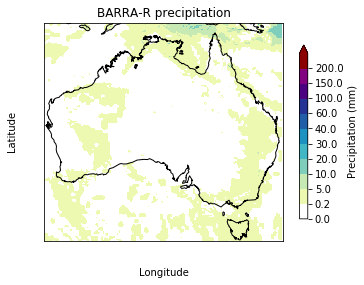

In [32]:
# a=Dataset('../../Data/da_pr_20121117_e01_bcsd.nc')
a=Dataset('../../Data/da_pr_20120317_e01.nc')

var=a['bcsd'][:][8]
lat=a['lat'][:]
lon=a['lon'][:]
a.close
dpt.draw_aus(var,lat,lon)

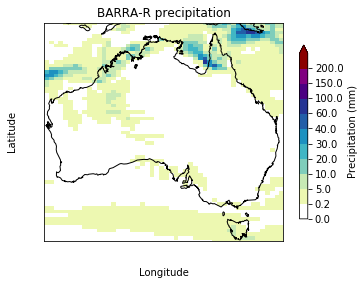

In [33]:
a=Dataset('../../Data/access/da_pr_20120317_e01.nc')
var=a['pr'][:][8]*86400
lat=a['lat'][:]
lon=a['lon'][:]
a.close
dpt.draw_aus(var,lat,lon)